In [1]:
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 解決MAC電腦 plot中文問題
plt.rcParams['axes.unicode_minus'] = False
tejapi.ApiConfig.api_key = "YOUR KEY"
tejapi.ApiConfig.ignoretz = True

In [2]:
data=tejapi.get('TWN/ANPRCSTD' ,chinese_column_name=True )
select=data["上市別"].unique()
select=select[1:3]
condition =(data["上市別"].isin(select)) & ( data["證券種類名稱"]=="普通股" )
data=data[condition]
twid=data["證券碼"].to_list()  #取得上市櫃股票證券碼

In [7]:
df = tejapi.get('TWN/AVIEW1', #從TEJ api撈取所需要的資料
                  chinese_column_name = True,
                  paginate = True,
                  mdate = {'gt':"2022-01-01", 'lt':'2022-08-31'},
                  coid=twid,
                  opts={'columns':['coid','mdate','close_d','kval','dval', 'dif','macd','a10ma']})

In [ ]:
df1 = tejapi.get('TWN/AVIEW1', #從TEJ api撈取所需要的資料
                  chinese_column_name = True,
                  paginate = True,
                  mdate = {'gt':'2021-01-01', 'lt':'2022-01-01'},
                  coid=twid,
                  opts={'columns':['coid','mdate','close_d','kval','dval', 'dif','macd','a10ma']})

In [ ]:
df2 = tejapi.get('TWN/AVIEW1', #從TEJ api撈取所需要的資料
                  chinese_column_name = True,
                  paginate = True,
                  mdate = {'gt':'2020-01-01', 'lt':'2021-01-01'},
                  coid=twid,
                  opts={'columns':['coid','mdate','close_d','kval','dval', 'dif','macd','a10ma']})

In [4]:
Y9999 = tejapi.get('TWN/AFUTR', #從TEJ api撈取所需要的資料
                  chinese_column_name = True,
                  paginate = True,
                  coid = 'ZTXA', 
                  mdate = {'gt':'2020-01-01', 'lt':'2022-08-31'},
                  opts={'columns':['coid','mdate','close_d']})

In [ ]:
df3 = pd.merge(df2,df1,how='outer')
df4 = pd.merge(df3, df, how='outer') #將抓下來的技術指標合起來
df4.set_index(df4["日期"], inplace=True) 
df4.drop(columns={'日期'}, inplace=True)
df4

In [20]:
condition1 = (df4["K值"] > df4["D值"]) &(df4["差離值"]> df4["MACD"]) & (df4["收盤價"] > df4["10日移動平均"])#日三線多指標的條件
condition2 = (df4["K值"] < df4["D值"]) &(df4["差離值"] < df4["MACD"]) & (df4["收盤價"] < df4["10日移動平均"])#日三線空指標的條件

In [21]:
long = df4[condition1] #把符合條件的篩選出來
short = df4[condition2]

In [22]:
long1 = ((long.groupby('日期')['證券碼'].count())/(df4.groupby('日期')['證券碼'].count()))*100 #計算出日三線多指標
short1 =((short.groupby('日期')['證券碼'].count())/(df4.groupby('日期')['證券碼'].count()))*100 #計算出日三線空指標
long1.name = '日三線多指標' #重新命名
short1.name = '日三線空指標'
result = pd.concat([long1,short1], axis=1) #把兩表合併起來

In [23]:
result

,日三線多指標,日三線空指標
日期,,
2020-01-02,37.484663,16.380368
2020-01-03,29.570552,23.619632
2020-01-06,17.791411,37.484663
2020-01-07,13.435583,46.748466
2020-01-08,8.895706,57.546012
...,...,...
2022-08-24,24.079662,18.044659
2022-08-25,26.992754,15.700483
2022-08-26,30.235365,13.759807


In [24]:
result1 = result.merge(Y9999[['日期', '收盤價']], on='日期')

In [26]:
result1['日多20ma'] = result1['日三線多指標'].rolling(20).mean()
result1['日空20ma'] = result1['日三線空指標'].rolling(20).mean()

In [27]:
result1.set_index(result1['日期'], inplace=True)
result1.drop(columns = {'日期'}, inplace=True)

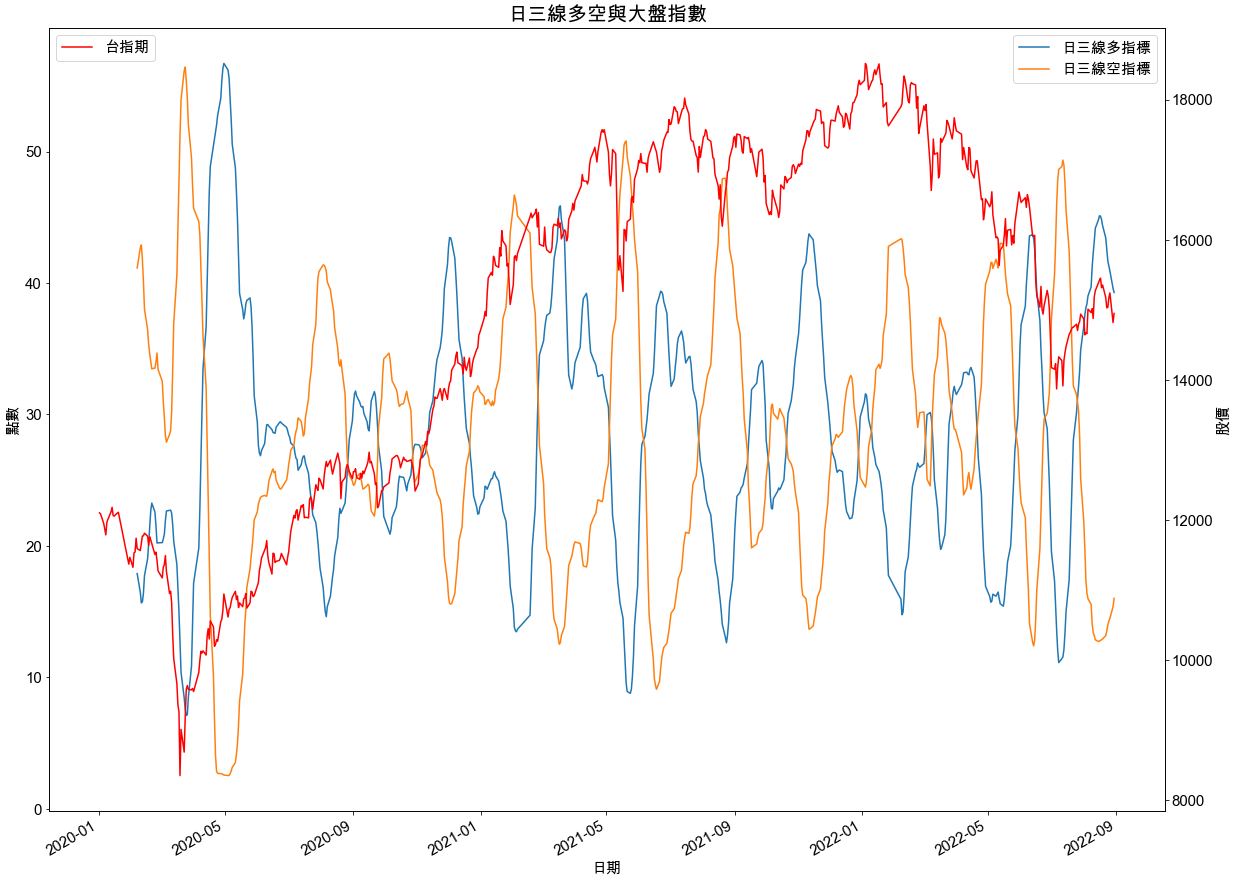

In [29]:
fig, ax1= plt.subplots(figsize =(20,16))
plt.plot(result1.index , result1['日多20ma'],lw=1.5, label = '日三線多指標')       
plt.plot(result1.index , result1['日空20ma'],lw=1.5, label = '日三線空指標')  
plt.xlabel('日期',fontsize=15)
plt.ylabel('點數', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('日三線多空與大盤指數',  fontsize=20)
plt.legend(loc=1, fontsize=15) 

ax2 = ax1.twinx() #跟第一張ax1的x軸一樣
plt.plot(result1.index, result1['收盤價'] , lw=1.5, color='r', label='台指期')
plt.ylabel('股價', fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc=2, fontsize=15)

plt.gcf().autofmt_xdate() #讓x軸的時間軸比較寬鬆、漂亮
plt.show()

In [30]:
def buysell(data,n1,n2):
    data =data.copy()
    buy=[]
    sell=[]
    hold=0
    data['日多ma'] = data['日三線多指標'].rolling(n1).mean()
    data['日空ma'] = data['日三線空指標'].rolling(n2).mean()
    data.dropna(inplace=True)
    for i in range(len(data)):
    
        if  data["日空ma"][i] > data["日多ma"][i]:
            sell.append(np.nan)
            if hold !=1:
                buy.append(data["收盤價"][i])
                
                hold = 1
            else: 
                buy.append(np.nan)
        elif data["日多ma"][i] > data["日空ma"][i] :
            buy.append(np.nan)
            if hold !=0:
                sell.append(data["收盤價"][i])
                hold = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    a=(buy,sell)
        
    data['Buy_Signal_Price']=a[0]
    data['Sell_Signal_Price']=a[1]
    data["買賣股數1"]=data['Buy_Signal_Price'].apply(lambda x : 1 if x >0 else 0)
    data["買賣股數2"]=data['Sell_Signal_Price'].apply(lambda x : -1 if x >0 else 0  )
    data["買賣股數"]=data["買賣股數1"]+ data["買賣股數2"]
    
    b = data[['Buy_Signal_Price']].dropna()
    c = data[['Sell_Signal_Price']].dropna()
    d = pd.DataFrame(index=c.index, columns = {"Buy_Signal_Price", 'Sell_Signal_Price'})
    for i in range(len(d.index)):
        d["Buy_Signal_Price"][i] = b["Buy_Signal_Price"][i]
        d['Sell_Signal_Price'][i] = c['Sell_Signal_Price'][i]
    d['hold_return'] = (d['Sell_Signal_Price']-d['Buy_Signal_Price'])/d['Buy_Signal_Price']
    win_rate = ((np.where(d['hold_return']>0, 1, 0).sum())/len(d.index))*100
    hold_ret = (d['hold_return'].sum())*100
    avg_ret = (d['hold_return'].mean())*100
    std = (d['hold_return'].std())*100
    
    final_equity = 10000
    for i in range(len(d.index)):
        final_equity = final_equity*(d['hold_return'][i]+1)
    cul_ret = ((final_equity-10000)/10000)*100
    y9999 = ((data['收盤價'][-1] - data['收盤價'][0])/data['收盤價'][0])*100
    
    #Visually show the stock buy and sell signal
    plt.figure(figsize=(20,16))
    # ^ = shift + 6
    plt.scatter(data.index,data['Buy_Signal_Price'],color='red', label='Buy',marker='^',alpha=1)
    #小寫的v
    plt.scatter(data.index,data['Sell_Signal_Price'],color='green', label='Sell',marker='v',alpha=1)
    plt.plot(data['收盤價'], label='Close Price', alpha=0.35)
    plt.title('買賣訊號', fontsize=20)
    #字斜45度角
    plt.xticks(rotation=45)
    plt.xlabel('Date', fontsize=15)  
    plt.ylabel('Price',fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.grid()
    plt.gcf().autofmt_xdate()
    return print(" 持有期間報酬:",hold_ret,"\n","平均報酬:",avg_ret,"\n",'交易次數:',len(d.index),'\n',"勝率:",win_rate,"\n","標準差:",std,'\n','權益總額:',final_equity,'\n','累積報酬率:',cul_ret,'\n','buy&hold:',y9999), plt.show()

 持有期間報酬: 16.56515841850869 
 平均報酬: 1.2742429552698993 
 交易次數: 13 
 勝率: 69.23076923076923 
 標準差: 6.701555152392263 
 權益總額: 11482.923282407217 
 累積報酬率: 14.82923282407217 
 buy&hold: 28.951000690131124


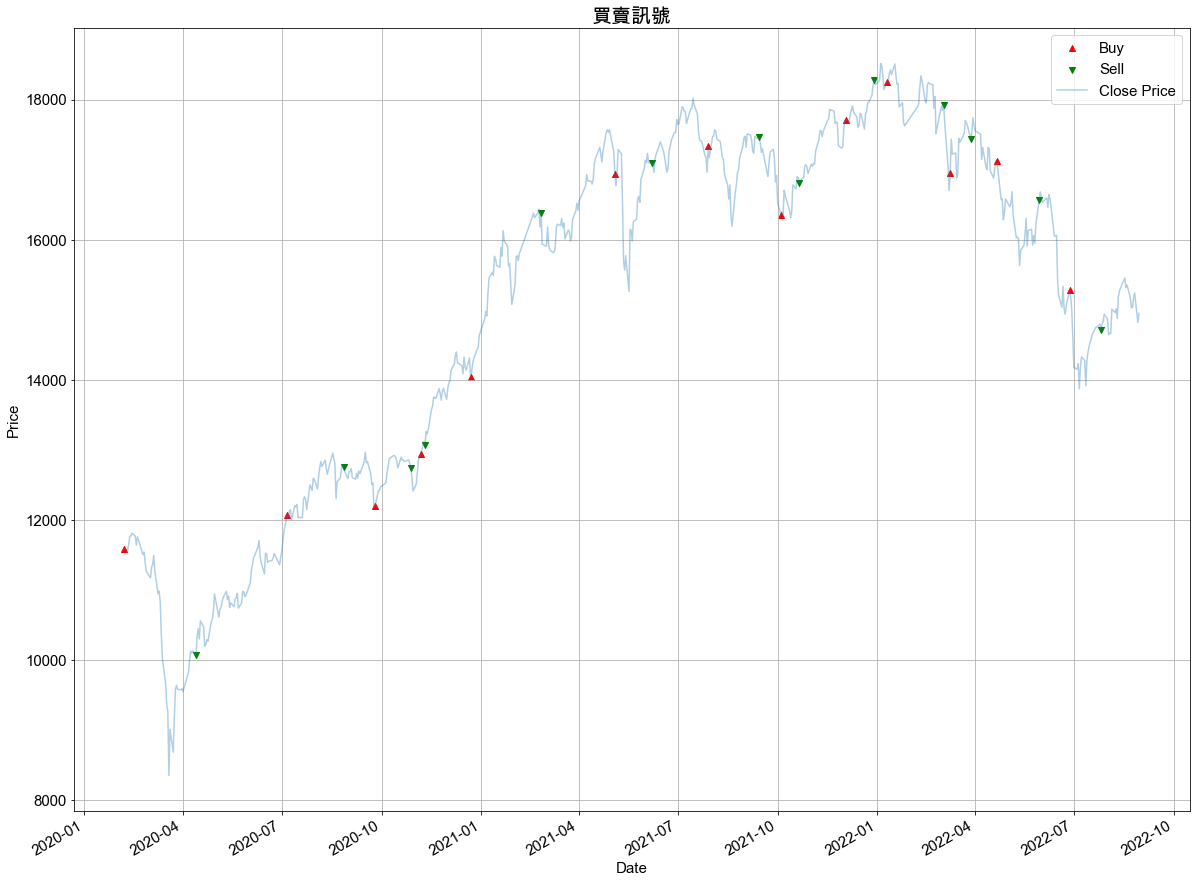

(None, None)

In [31]:
buysell(result1,20,20)

In [ ]:
# def plot(data):
# #Visually show the stock buy and sell signal
#     plt.figure(figsize=(20,16))
# # ^ = shift + 6
#     plt.scatter(data.index,data['Buy_Signal_Price'],color='red', label='Buy',marker='^',alpha=1)
# #小寫的v
#     plt.scatter(data.index,data['Sell_Signal_Price'],color='green', label='Sell',marker='v',alpha=1)
#     plt.plot(data['Close'], label='Close Price', alpha=0.35)
#     plt.title('Close Price Buy & Sell Signals')
# #字斜45度角
#     plt.xticks(rotation=45)
#     plt.xlabel('Date')  
#     plt.ylabel('Price')
#     plt.legend()
#     plt.grid()
#     plt.gcf().autofmt_xdate()
#     return  plt.show()

In [33]:
def optimal(data1,n1:range, n2:range):
    set_0 = 0
    for i in n1:
        for j in n2:
            data =data1.copy()
            buy=[]
            sell=[]
            hold=0
            data['日多ma'] = data['日三線多指標'].rolling(i).mean()
            data['日空ma'] = data['日三線空指標'].rolling(j).mean()
            data.dropna(inplace=True)
            for k in range(len(data)):

                if  data["日空ma"][k] > data["日多ma"][k]:
                    sell.append(np.nan)
                    if hold !=1:
                        buy.append(data["收盤價"][k])

                        hold = 1
                    else: 
                        buy.append(np.nan)
                elif data["日多ma"][k] > data["日空ma"][k]:
                    buy.append(np.nan)
                    if hold !=0:
                        sell.append(data["收盤價"][k])
                        hold = 0
                    else:
                        sell.append(np.nan)
                else:
                    buy.append(np.nan)
                    sell.append(np.nan)
            a=(buy,sell)

            data['Buy_Signal_Price']=a[0]
            data['Sell_Signal_Price']=a[1]
            data["買賣股數1"]=data['Buy_Signal_Price'].apply(lambda x : 1 if x >0 else 0)
            data["買賣股數2"]=data['Sell_Signal_Price'].apply(lambda x : -1 if x >0 else 0  )
            data["買賣股數"]=data["買賣股數1"]+ data["買賣股數2"]

            b = data[['Buy_Signal_Price']].dropna()
            c = data[['Sell_Signal_Price']].dropna()
            d = pd.DataFrame(index=c.index, columns = {"Buy_Signal_Price", 'Sell_Signal_Price'})
            for l in range(len(d.index)):
                d["Buy_Signal_Price"][l] = b["Buy_Signal_Price"][l]
                d['Sell_Signal_Price'][l] = c['Sell_Signal_Price'][l]
            d['hold_return'] = (d['Sell_Signal_Price']-d['Buy_Signal_Price'])/d['Buy_Signal_Price']

            final_equity = 10000
            for m in range(len(d.index)):
                final_equity = final_equity*(d['hold_return'][m]+1)
            cul_ret = ((final_equity-10000)/10000)*100
            if cul_ret>= set_0:
                set_0 = cul_ret
                n1_new = i
                n2_new = j
    return print(' n1:',n1_new,'\n', 'n2:', n2_new,"\n", '累積報酬:', set_0)

In [34]:
optimal(result1, n1=range(0,30), n2 =range(0,30) )

 n1: 19 
 n2: 13 
 累積報酬: 40.48308734776532


 持有期間報酬: 36.5529556976841 
 平均報酬: 2.284559731105256 
 交易次數: 16 
 勝率: 68.75 
 標準差: 5.335857673183779 
 權益總額: 14048.308734776532 
 累積報酬率: 40.48308734776532 
 buy&hold: 28.951000690131124


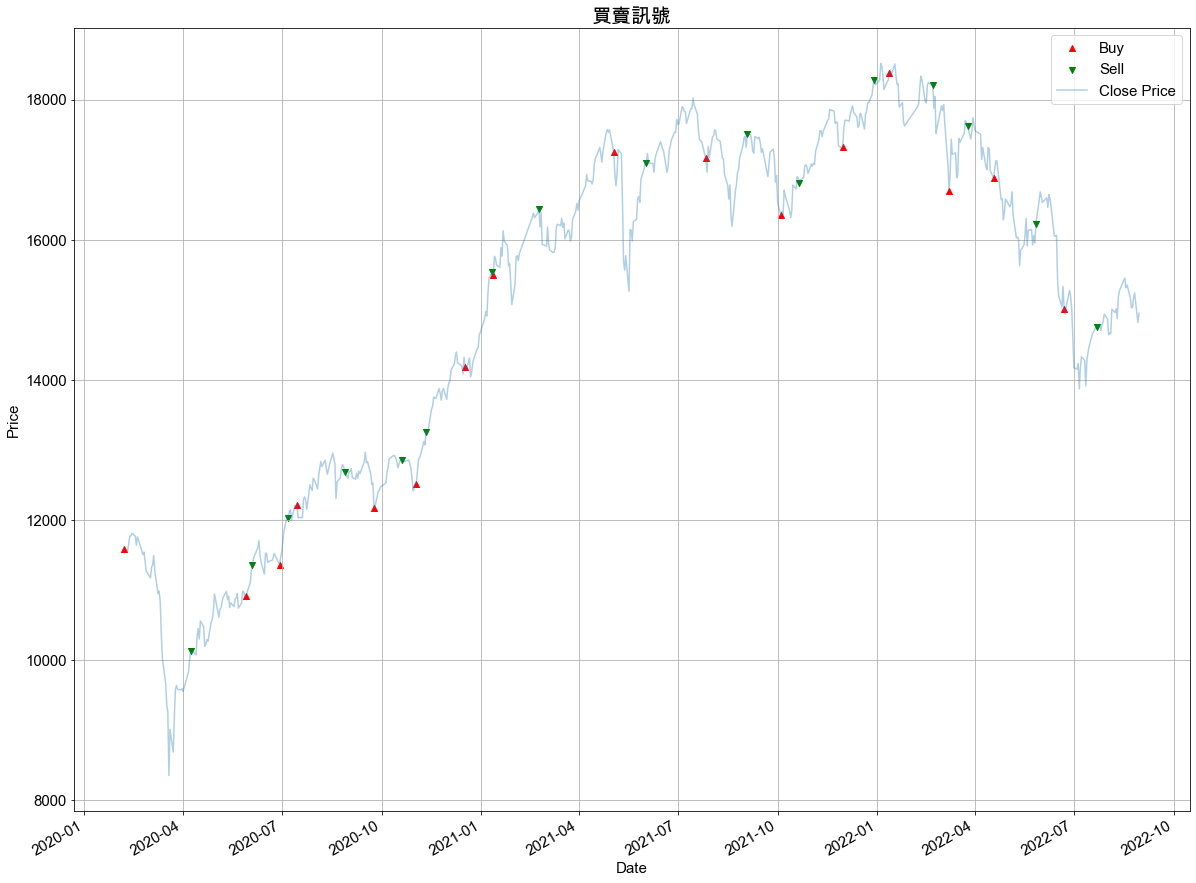

(None, None)

In [35]:
buysell(result1,19,13)